## 8-Puzzle Game

> ### Overview
The 8-Puzzle game consists of a 3x3 grid with 9 spaces consisting of 8 numbered tiles and one empty space. The game's initial state is a random order with the aim of the goal being to reach the desired goal state. The game is restricted by these following rules:

1. Goal: Go from *Initial State* to *Goal State*
2. Legal Actions: Up, Down, Left,Right
    - Only one tile to be moved at one time.
    - Tiles can only move if adjacent to empty space in current state

The game can be implemented as a search problem with th eplayer searching for a path from the *Initial State* to the *Goal State* by rearranging the tiles.

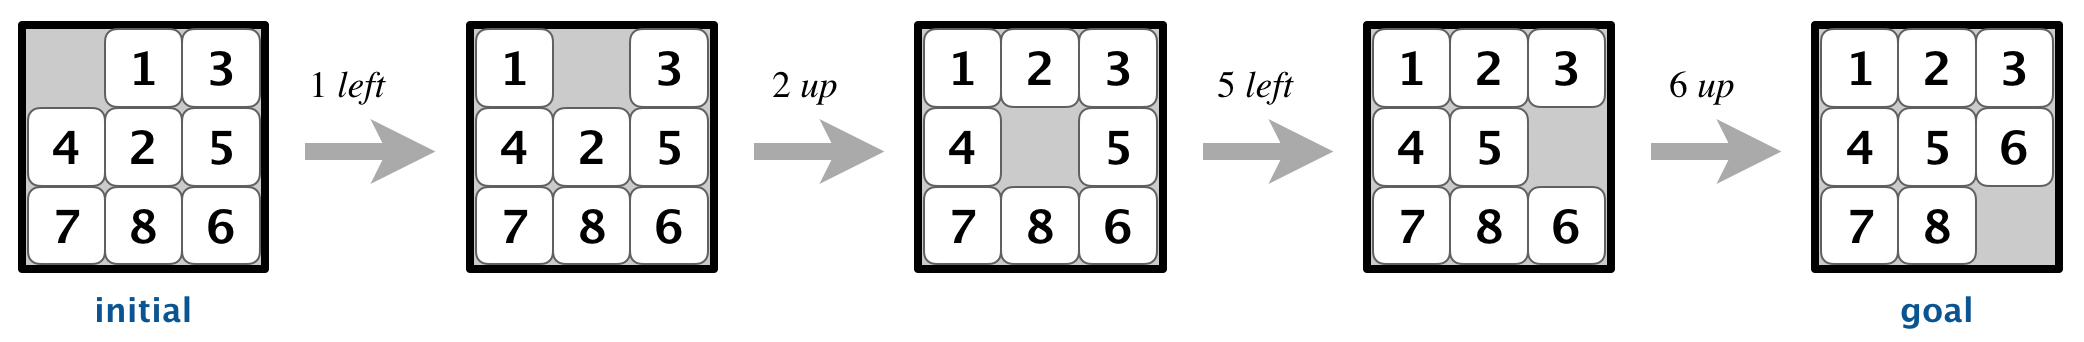

> ### A* Algorithm

Heuristics are *informed* problem-solving methods, this means that they use an esitmation fo the fastest path to the solution. This time efficient solution is based on a simple set of given rules *(i.e in our case being the rules of the puzzle)*

The A* Algorithm is an algorithm that employs heuristic functions to find the path in a state tree with the lowest cost from the *Initial State* to *Goal State*. The algorithm keeps track of all nodes visited and does not explore paths with a higher cost.

In short, the A* algorithm is a popular and powerful search algorithm used for pathfinding and graph traversal. It works by:

* Keeping a priority queue (often implemented using a min-heap) of paths according to the cost function f(n).
* Expanding the most promising node first, where promising is defined by the lowest f(n) value.


> ### Function behind A* Algorithm

The function uses the following function to estimate the cost of every move.

``` f(n) = g(n) + h(n) ```

__*f(n)*__: Total cost of path through node *n* </br>
__*g(n)*__: The actual cost from the initial state to the current node n.
__*h(n)*__: The heuristic estimated cost from node n to the goal state.

- Can be calculated using Manhatten Distance from node *n* to *Goal State*.
- Sum of distance of vertical and horizontal steps between two points.

> ### Types of Heuristic Functions
1. *h<sub>1</sub>(n)* : Number of misplaced tiles
2. *h<sub>2</sub>(n)* : sum of Manhatten Distance for every tile from *Current State* to *Goal State*

> ### Reason behind Admission of Fucntions:
1. Both functions do not overestimate the cost of moves to *Goal State*
2. h<sub>1</sub>
    - *Initital State* will always be misplaced and will have to be moved to reach goal state
3. h<sub>2</sub>
    - Every move made by agent will be one step closer to *Goal State*
4. Our goal is to minimize both H<sub>1</sub> and H<sub>2</sub>, bringing us closer to goal state

> ### Implementing A* for 8-Puzzle
When implementing A* for the 8-puzzle, one would:

1. Define the initial state, goal state, and state space where the states represent different tile arrangements.

2. Define the g(n) function to track the number of moves made from the initial state.

3. Choose a heuristic function (h1(n) or h2(n)) to estimate the remaining cost to the goal state.

4. Use a priority queue to manage the nodes, prioritizing them based on their f(n) values.

5. Expand nodes starting with the one with the lowest f(n), generating successors by applying legal moves.

6. Check for the goal state upon expanding each node. If the goal state is reached, reconstruct the solution path from the initial state to the goal state.

7. Avoid revisiting states by keeping a closed list of already expanded nodes.

The A* algorithm will continue to iterate through this process until the goal state is found. The efficiency and effectiveness of the algorithm are highly dependent on the heuristic function chosen. If the heuristic closely represents the actual cost, A* will perform fewer expansions and find the solution more quickly. However, even with a less accurate heuristic, A* will still find the optimal solution, provided the heuristic is admissible.

### 8-Puzzle Solver: Implementing A* Algorithm

> ### Import required libraries 

In [85]:
import time
from heapq import heappush, heappop
from collections import deque
from math import sqrt
import pandas as pd
import time
from random import shuffle

> ### Defining State of Puzzle
Initialize a new state in the puzzle search tree.

##### Parameters:
* state (list): The current configuration of the puzzle as a list of integers.
* parent (State): The parent state from which the current state was reached.
* move (str): The move made to reach the current state from the parent state.
* depth (int): The depth of the current state in the search tree.
* cost (int): The cost of reaching the current state from the start state.
* key (int): The priority key for the current state used in priority queues.

In [73]:
class State:
    def __init__(self, state: list, parent: 'State', move: str, depth: int, cost: int, key: int):

        self.state = state  # Current puzzle configuration
        self.parent = parent  # Parent state reference
        self.move = move  # Move made from parent to current state
        self.depth = depth  # Depth of current state in search tree
        self.cost = cost  # Cumulative cost to reach current state
        self.key = key  # Priority key for search algorithm

        # Create a unique string representation of the state for easy comparison and hashing.
        self.map = ''.join(str(tile) for tile in self.state) if self.state else ''

    def __eq__(self, other: 'State') -> bool:
        """Check if two states are equal based on their string representation."""
        return self.map == other.map

    def __lt__(self, other: 'State') -> bool:
        """Define a less-than relation between two states for sorting purposes."""
        return self.map < other.map

> ### Inititializing *Goal State*, *Initial State* other parameters

In [74]:
goalState = [1,2,3,4,5,6,7,8,0]
goalNode = State
initialState = []   
puzzleLen = 9       
puzzleSide = 3      
nodesExpanded = 0   
maxDepthReached = 0 
maxFringeSize = 0   
moves = []       


> ### Defining legal moves

In [75]:
def legalMove(state, position):
    # Function to check that the move is legal
    newState = state[:]
    index = newState.index(0) 
    if position == 'UP': 
        if index not in range(0, puzzleSide):           
            temp = newState[index - puzzleSide]
            newState[index - puzzleSide] = newState[index]
            newState[index] = temp
            return newState
        else:
            return None
    if position == 'DOWN':        
        if index not in range(puzzleLen - puzzleSide, puzzleLen):
            temp = newState[index + puzzleSide]
            newState[index + puzzleSide] = newState[index]
            newState[index] = temp
            return newState
        else:
            return None
    if position == 'LEFT': 
        if index not in range(0, puzzleLen, puzzleSide):
            temp = newState[index - 1]
            newState[index - 1] = newState[index]
            newState[index] = temp
            return newState
        else:
            return None
    if position == 'RIGHT': 
        if index not in range(puzzleSide - 1, puzzleLen, puzzleSide):
            temp = newState[index + 1]
            newState[index + 1] = newState[index]
            newState[index] = temp
            return newState
        else:
            return None

> ### Defining subsequent moves and their effects:

The ***expand*** function takes a single node (which is an instance of the State class) as an argument and generates all possible successors (children) of that node based on the possible moves that can be made in the puzzle. 

***nodesExpanded*** is a global variable, which keeps track of the total number of nodes expanded during the search process. ***nodesExpanded*** += 1 increments this counter, signaling that the current node is being expanded

A new list called ***childNodes*** is created to store the State objects that represent the children of the current node.

The ***legalMove*** function is called for each possible move direction ('DOWN', 'LEFT', 'RIGHT', 'UP'). This function returns the new state of the puzzle after making the move if the move is legal. If the move is illegal (e.g., moving 'UP' when the empty space is already in the top row), legalMove returns None.

For each move, a new ***State*** object is created with the following parameters:

* The new puzzle state after the move (legalMove(node.state, <DIRECTION>)),
* A reference to the current node as the parent (node),
* The move that was made to reach this state ('DOWN', 'LEFT', 'RIGHT', or 'UP'),
* The depth of the new node, which is one greater than the current node's depth (node.depth + 1),
* The cost to reach the new node, which is one greater than the current node's cost (node.cost + 1),
* The key for the new node, which is temporarily set to 0 

Then a list comprehension is used to filter out any child nodes that have a None state, which would indicate an illegal move was attempted. Only child nodes that represent legal moves (with a valid state) are kept in the nodes list.

Lastly the function returns the nodes list, which contains all the legal children of the current node.


In [76]:
def expand(node):
    global nodesExpanded
    nodesExpanded += 1
    childNodes = []
    childNodes.append(State(legalMove(node.state,'DOWN'),node,'DOWN',node.depth + 1, node.cost + 1, 0)) 
    childNodes.append(State(legalMove(node.state,'LEFT'),node,'LEFT',node.depth + 1, node.cost + 1, 0)) 
    childNodes.append(State(legalMove(node.state,'RIGHT'),node,'RIGHT',node.depth + 1, node.cost + 1, 0))
    childNodes.append(State(legalMove(node.state,'UP'),node,'UP',node.depth + 1, node.cost + 1, 0))
    nodes = [child for child in childNodes if child.state]
    return nodes

>### ***get*** function to parse the puzzle data and calculate puzzle dimensions

In [77]:

def get(dataList: str):
    """Parse the puzzle data and calculate puzzle dimensions."""
    global init_state, puzzleLen, puzzleSide
    # Split the input comma-separated string into a list of strings
    data = dataList.split(',') 
    # Clear the initial state list and populate it with integers from the input data
    init_state.clear()
    for element in data:
        init_state.append(int(element))  # Convert each string to an integer
    # Calculate the total number of puzzle elements
    puzzleLen = len(init_state)
    # Calculate the side length of the puzzle (e.g., 3 for a 3x3 puzzle)
    puzzleSide = int(sqrt(puzzleLen))

> ### Agent Implementation
#### A* search algorithm

The ***astar*** function implements the **A* search algorithm** to find a solution to a puzzle. It takes two arguments: startState, which is the initial configuration of the puzzle, and heuristicFunc, which is a function used to calculate the heuristic value ( h(n) ) for a given state. This heuristic is an estimate of the cost from the current state to the goal state. He

- input parameters:
    1. StartState
        - Input array (i.e. [0,7,5,3,2,4,6,1])
    2. Heuristic Functions *h<sub>n</sub>(n)*

1. Initialization:
    * global ***goalNode***, ***maxFringeSize***, ***maxDepthReached*** declares that the function will be using these global variables to store the goal node once it's found, track the maximum size of the fringe (the set of candidate nodes to be explored), and record the maximum depth reached during the search, respectively.\
    * ***visited*** is a set that will store the string representations (map) of all visited states to avoid revisiting them.\
    * ***pQueue*** is a priority queue that will store nodes to be explored, with the lowest heuristic cost having the highest priority.\

2. Create Root Node:
    * The ***key*** for the root node is calculated by calling the ***heuristic function*** on the ***startState***.
    * A new ***State*** object representing the ***root node*** is created with the ***startState***, no ***parent***, no ***move leading*** to it, a ***depth*** of 0, a ***cost*** of 0, and the ***heuristic key***.
    * An ***entry*** tuple containing the ***key***, a ***secondary sort key*** , and the ***root State*** is pushed onto the ***priority queue pQueue***.

3. Search Loop:
    * The ***function*** enters a loop that continues as long as there are ***nodes*** in the ***priority queue***.
    * The ***node*** with the **lowest** ***heuristic cost*** is **popped** from the ***priority queue***.
    * The ***map*** of this node is added to the ***visited set*** to mark it as **explored**.
    * If the ***node***'s state is equal to the ***goalState*** , the ***goalNode*** is set to this ***node***, and the ***function*** returns True and the ***current pQueue***, indicating success.

4. Expand Neighbors:
    * The ***expand function*** is called on the ***current node*** to generate its ***neighbors***, representing all possible ***legal moves*** from the ***current state***.
    * Each ***neighbor (child node)*** is assigned a ***key*** that is the **sum of its cost** (from start to this node) and the **estimated cost** to reach the goal as determined by ***heuristicFunc***.

5. Process Neighbors:
    * For each ***neighbor***, an ***entry*** is created with its ***key***, the ***move*** leading to it, and the ***neighbor*** itself.
    * If the ***neighbor*** has *not been visited* (its map is not in the visited set), it is added to the ***priority queue*** and marked as visited.
    * If the ***neighbor's depth*** is greater than ***maxDepthReached***, then ***maxDepthReached*** is updated to this new depth.

6. Update Fringe Size:
    * After processing ***neighbors***, if the length of the ***priority queue*** exceeds ***maxFringeSize***, then ***maxFringeSize*** is updated to the ***current length*** of the ***priority queue***.

7. Return Value:
    * If the loop exits without finding the ***goal state***, the function returns False and None, indicating failure.

In [78]:
def astar(startState, heuristicFunc): 
#defining the astar function with 2 parameter --- 
#1. initial condition 
#2. function used to calculate  heuristic value (h(n)) for a given state.
    global goalNode, maxFringeSize, maxDepthReached
    visited, pQueue = set(), list()
    key = heuristicFunc(startState)
    root = State(startState, None, None, 0, 0, key)
    entry = (key, 0, root)
    heappush(pQueue, entry)
    while pQueue:
        node = heappop(pQueue)
        visited.add(node[2].map)
        if node[2].state == goalState:
            goalNode = node[2]
            return True, pQueue
        neighbors = expand(node[2])
        for neighbor in neighbors:
            neighbor.key = neighbor.cost + heuristicFunc(neighbor.state)
            entry = (neighbor.key, neighbor.move, neighbor)
            if neighbor.map not in visited:
                heappush(pQueue, entry)
                visited.add(neighbor.map)
                if neighbor.depth > maxDepthReached:
                    maxDepthReached += 1                    
        if len(pQueue) > maxFringeSize:
            maxFringeSize = len(pQueue)
    return False, None

> ### Heuristic Functions
* The heuristic h1 is known as the "hamming distance", it simply counts how many tiles are out of place, , without considering the distance each out-of-place tile is from its goal position
* The heuristic h2 is known as the "Manhattan Distance" between two points. It is the sum of the absolute differences of their coordinates. In the case of the 8-puzzle, this translates to the sum of the vertical and horizontal distance between each tile's current position and its goal position.

In [79]:
def h1(state):
    count = 0
    for i in range(0, 9):
        if not (state.index(i) == goalState.index(i)) : 
            count+=1
    return count 

def h2(state): 
    return sum(abs(p%puzzleSide - g%puzzleSide) + abs(p//puzzleSide - g//puzzleSide)
               for p,g in ((state.index(i),goalState.index(i)) 
               for i in range(1, 9))) 

>### Backtrack function
* to construct the sequence of moves that leads from the initial state of a puzzle to the goal state after a solution has been found. 

In [80]:
def backtrack():
    global goalNode
    moves = []
    if goalNode is not None:
        currentNode = goalNode
        while currentNode.parent is not None:  
            moves.insert(0, currentNode.move)
            currentNode = currentNode.parent
    return moves

>### output function
* The output function provides a structured way to display the results of the search algorithm used to solve a puzzle.
* It takes three parameters: 
    * fringe, which represents the set of candidate nodes to be explored
    * time, which indicates the time taken to reach the solution
    * testNum, identifier for the test case but is not used within the function.

In [81]:
def output(fringe, time, testNum):

    if goalNode is not None:  # Check if goalNode is not None instead of checking fringe
        moves = backtrack()
        print("<-- # SOLUTION DETAILS # -->")
        print("\n Initial State: "+str(initialState))
        print("\n Path to goal: " + str(moves))
        print("\n Cost(Moves): " + str(len(moves)))
        print("\n Node count: " + str(nodesExpanded))
        print("\n Fringe size: " + str(len(fringe)))
        print("\n Tree depth: " + str(goalNode.depth))
        print("\n Run time: " + format(time, '.8f'))
    else:
        print("<-- # NO SOLUTION # -->")
        print("\n Node count: " + str(nodesExpanded))
        print("\n Max fringe: " + str(maxFringeSize))
        print("\n Max tree depth: " + str(maxDepthReached))
        print("\n Run time: " + format(time, '.8f'))

In [82]:
def print_puzzle(state):
    """Prints the 8-puzzle state in a grid format."""
    puzzle_side = int(sqrt(len(state)))  # Calculate the side length of the puzzle
    puzzle_grid = [state[i:i + puzzle_side] for i in range(0, len(state), puzzle_side)]  # Create a list of lists for each row

    for row in puzzle_grid:
        row_str = ' | '.join(f'{num if num > 0 else " "}' for num in row)  # Replace 0 with a space for better visibility
        print(row_str)
        print('-' * (puzzle_side * 4 - 1))  # Print a separator line

In [87]:
def generate_random_state():
    state = list(range(9))  # Generates a list [0, 1, ..., 8]
    shuffle(state)          # Shuffles the list to create a random initial state
    return state


In [104]:
import pandas as pd
import time

heuristic_map = {'h1': h1, 'h2': h2}

# Generate 10 random initial states and store them in a DataFrame
states_data = {
    'Initial State': [],
    'Heuristic': [],
    'Solution Found': [],
    'Time Taken': [],
    'Moves': [],
    'Tree depth': []
}

for i in range(30):
    init_state = generate_random_state()
    for heuristic_name, heuristic_func in heuristic_map.items():
        print(f"Iteration: {i + 1}, Heuristic: {heuristic_name}")
                    
        start_time = time.time()
        search, fringe = astar(init_state, heuristic_func)
        end_time = time.time()
        
        # Record the data
        states_data['Initial State'].append(init_state)
        states_data['Heuristic'].append(heuristic_name)
        states_data['Solution Found'].append(search)
        states_data['Time Taken'].append(end_time - start_time)
        states_data['Tree depth'].append(goalNode.depth)
        
        # If a solution is found, use the backtrack function to get the moves
        if search:
            moves = backtrack()
        else:
            moves = []
        states_data['Moves'].append(moves)

# Create DataFrame from the collected data
df_states = pd.DataFrame(states_data)

# Display the DataFrame
print(df_states)



Iteration: 1, Heuristic: h1
Iteration: 1, Heuristic: h2
Iteration: 2, Heuristic: h1
Iteration: 2, Heuristic: h2
Iteration: 3, Heuristic: h1
Iteration: 3, Heuristic: h2
Iteration: 4, Heuristic: h1
Iteration: 4, Heuristic: h2
Iteration: 5, Heuristic: h1
Iteration: 5, Heuristic: h2
Iteration: 6, Heuristic: h1
Iteration: 6, Heuristic: h2
Iteration: 7, Heuristic: h1
Iteration: 7, Heuristic: h2
Iteration: 8, Heuristic: h1
Iteration: 8, Heuristic: h2
Iteration: 9, Heuristic: h1
Iteration: 9, Heuristic: h2
Iteration: 10, Heuristic: h1
Iteration: 10, Heuristic: h2
Iteration: 11, Heuristic: h1
Iteration: 11, Heuristic: h2
Iteration: 12, Heuristic: h1
Iteration: 12, Heuristic: h2
Iteration: 13, Heuristic: h1
Iteration: 13, Heuristic: h2
Iteration: 14, Heuristic: h1
Iteration: 14, Heuristic: h2
Iteration: 15, Heuristic: h1
Iteration: 15, Heuristic: h2
Iteration: 16, Heuristic: h1
Iteration: 16, Heuristic: h2
Iteration: 17, Heuristic: h1
Iteration: 17, Heuristic: h2
Iteration: 18, Heuristic: h1
Ite

In [101]:
import matplotlib.pyplot as plt

def plot_heuristics_by_time(df_states):
    # Filter the DataFrame for each heuristic
    df_h1 = df_states[df_states['Heuristic'] == 'h1']
    df_h2 = df_states[df_states['Heuristic'] == 'h2']
    
    # Assuming the index represents the order of initial states
    x = range(1, len(df_h1) + 1)
    
    # Plotting both heuristics on the same graph
    plt.plot(x, df_h1['Time Taken'], label='h1 - Number of Misplaced Tiles', marker='o')
    plt.plot(x, df_h2['Time Taken'], label='h2 - Sum of Manhattan Distances', marker='o')
    
    # Adding labels and title
    plt.xlabel('Initial State Index')
    plt.ylabel('Time Taken (seconds)')
    plt.title('Comparison of Heuristic Functions')
    plt.legend()
    
    # Show grid
    plt.grid(True)
    
    # Show the plot
    plt.show()

def plot_heuristics_by_depth(df_states):
    # Filter the DataFrame for each heuristic
    df_h1 = df_states[df_states['Heuristic'] == 'h1']
    df_h2 = df_states[df_states['Heuristic'] == 'h2']
    
    # Assuming the index represents the order of initial states
    x = range(1, len(df_h1) + 1)
    
    # Plotting both heuristics on the same graph
    plt.plot(x, df_h1['Tree depth'], label='h1 - Number of Misplaced Tiles', marker='o')
    plt.plot(x, df_h2['Tree depth'], label='h2 - Sum of Manhattan Distances', marker='o')
    
    # Adding labels and title
    plt.xlabel('Initial State Index')
    plt.ylabel('Tree Depth')
    plt.title('Comparison of Heuristics by Tree Depth')
    plt.legend()
    
    # Show grid
    plt.grid(True)
    
    # Show the plot
    plt.show()



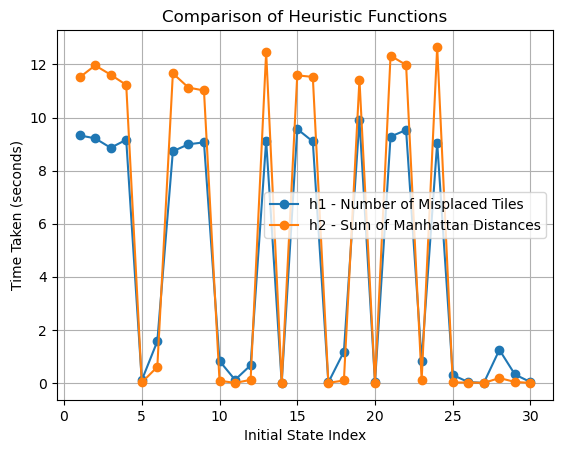

In [105]:
plot_heuristics_by_time(df_states)

possible reason why h2 generally take longer time when there is no solution, but shorter time when there is a solution:

1. Admissibility and Consistency:
    * An admissible heuristic is one that never overestimates the cost to reach the goal from any node in the search space. A consistent (or monotonic) heuristic, in addition to being admissible, also satisfies the condition that its estimate is always less than or equal to the estimated distance from any neighboring node to the goal plus the cost of reaching that neighbor.
    * If h2 is consistent (and thus also admissible), while h1 is just admissible, h2 will potentially be more informed. This means that h2 can guide the search more effectively towards the goal when a solution exists, possibly resulting in a shorter search time.

2. Heuristic Informativeness:
    * If h2 is a more informative heuristic (meaning it provides a closer approximation to the actual cost from a node to the goal), it will generally expand fewer nodes than h1 when searching for a solution, leading to faster solutions when they exist.
    * However, if no solution exists, the more informative h2 might explore more of the search space to confirm that no solution is possible, especially if the search space is large or infinite. In contrast, a less informative heuristic, like h1, might fail faster because it does not guide the search as effectively and might reach a dead end sooner.

3. Search Space Coverage:
    * When there is no solution, the algorithm with h2 might end up exploring more of the search space before concluding that no solution exists because it is systematically eliminating more possibilities due to its more accurate guidance.
    * On the other hand, if there is a solution, h2 will guide the algorithm more directly to the goal, thus taking less time.


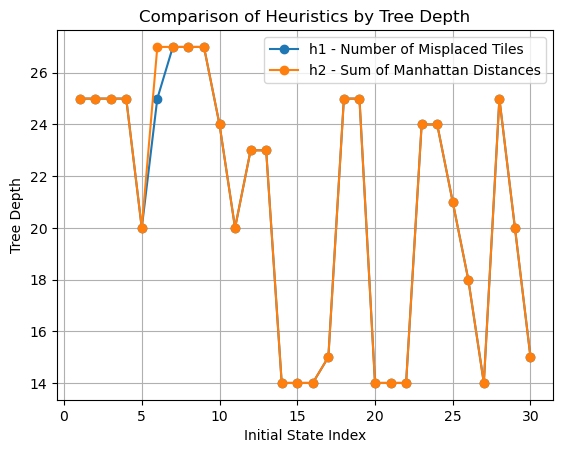

In [106]:
plot_heuristics_by_depth(df_states)


In [107]:
df_states

,Initial State,Heuristic,Solution Found,Time Taken,Moves,Tree depth
0,"[2, 5, 0, 3, 7, 4, 6, 8, 1]",h1,False,9.326484,[],25
1,"[2, 5, 0, 3, 7, 4, 6, 8, 1]",h2,False,11.510668,[],25
2,"[4, 6, 2, 1, 3, 0, 7, 5, 8]",h1,False,9.217017,[],25
3,"[4, 6, 2, 1, 3, 0, 7, 5, 8]",h2,False,11.964856,[],25
4,"[3, 5, 4, 1, 6, 2, 8, 0, 7]",h1,False,8.859689,[],25
5,"[3, 5, 4, 1, 6, 2, 8, 0, 7]",h2,False,11.613580,[],25
6,"[5, 8, 7, 1, 4, 0, 6, 2, 3]",h1,False,9.163507,[],25
7,"[5, 8, 7, 1, 4, 0, 6, 2, 3]",h2,False,11.230412,[],25
8,"[5, 4, 1, 3, 7, 2, 6, 8, 0]",h1,True,0.099587,"[LEFT, UP, LEFT, UP, RIGHT, RIGHT, DOWN, LEFT,...",20
9,"[5, 4, 1, 3, 7, 2, 6, 8, 0]",h2,True,0.016875,"[LEFT, UP, LEFT, UP, RIGHT, RIGHT, DOWN, LEFT,...",20


Both take equal number of steps to get to the solution 